In [230]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt

In [73]:
with open('dataset.txt') as f:
	text = f.read()

vocabulary = sorted(list(set(text)))
vocab_size = len(vocabulary)

stoi = {v:i for i, v in enumerate(vocabulary)}
itos = {i:v for i, v in enumerate(vocabulary)}

def encode(s): return [stoi[c] for c in s]
def decode(i): return [itos[n] for n in i]

In [207]:
data = torch.tensor(encode(text))

split_v = int(0.9 * len(data))

train = data[:split_v]
test = data[split_v:]

In [276]:
batch_size = 16
block_size = 32
embedding_dimensions = 64
num_heads = 4
head_size = embedding_dimensions // num_heads
num_decoders = 4
learning_rate = 0.01
iterations = 10000
device = 'mps'

In [192]:
def get_batch(data):
    indexes = torch.randint(0, len(data)-block_size, (batch_size,))
    inputs = torch.stack([data[i:i+block_size] for i in indexes]).to(device)
    outputs = torch.stack([data[i+1:i+block_size+1] for i in indexes]).to(device)

    return inputs, outputs

In [154]:
class FeedForward(nn.Module):
	def __init__(self):
		super().__init__()
		self.network = nn.Sequential(
			nn.Linear(embedding_dimensions, embedding_dimensions),
			nn.ReLU(),
			nn.Linear(embedding_dimensions, embedding_dimensions)
		)

	def forward(self, data):
		return self.network(data)
	
test = FeedForward().forward(torch.randn(embedding_dimensions))

In [155]:
class AttentionHead(nn.Module):
	def __init__(self):
		super().__init__()
		self.key = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.query = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.value = nn.Linear(embedding_dimensions, head_size, bias=False)
		self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

	def forward(self, data):
		batches, time, channels = data.shape

		key, query, value = self.key(data), self.query(data), self.value(data)
		mat_mul_1 = query @ key.transpose(-2, -1)
		scaled = mat_mul_1 / sqrt(channels)
		mask = scaled.masked_fill(self.tril == 0, float('-inf'))
		softmax = F.softmax(mask, dim=-1)
		out = softmax @ value

		return out

test = AttentionHead().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [149]:
class MultiHeadAttention(nn.Module):
	def __init__(self):
		super().__init__()
		self.heads = nn.ModuleList([AttentionHead() for _ in range(num_heads)])
		self.projection = nn.Linear(embedding_dimensions, embedding_dimensions)
	
	def forward(self, data):
		return self.projection(torch.cat([head(data) for head in self.heads], dim=-1))

test = MultiHeadAttention().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [195]:
class DecoderBlock(nn.Module):
	def __init__(self):
		super().__init__()
		self.attention = MultiHeadAttention()
		self.norm1 = nn.LayerNorm(embedding_dimensions)
		self.feed_forward = FeedForward()
		self.norm2 = nn.LayerNorm(embedding_dimensions)

	def forward(self, data):
		data = data + self.attention(self.norm1(data))
		data = data + self.feed_forward(self.norm2(data))

		return data

test = DecoderBlock().forward(torch.randn((batch_size, block_size, embedding_dimensions)))

In [274]:
class GPT(nn.Module):
	def __init__(self):
		super().__init__()
		self.embedding_space     = nn.Embedding(vocab_size, embedding_dimensions)
		self.positional_encoding = nn.Embedding(block_size, embedding_dimensions)
		self.blocks = nn.Sequential(*[DecoderBlock() for _ in range(num_decoders)])
		self.norm = nn.LayerNorm(embedding_dimensions)
		self.linear = nn.Linear(embedding_dimensions, vocab_size)
		
	def forward(self, data, outputs=None):
		batches, time = data.shape

		data = self.embedding_space(data) + self.positional_encoding(torch.arange(time, device=device))
		data = self.blocks(data)
		logits = self.linear(data)

		if outputs is not None:
			batches, time, channels = logits.shape
			loss = F.cross_entropy(logits.view(batches*time, channels), outputs.view(batches*time))
		else:
			loss = None

		return logits, loss
	
	def generate(self, input, num_tokens):
		for _ in range(num_tokens):
			input_clipped = input[:,-block_size:]
			logits,_ = self(input_clipped)
			logits = logits[:, -1, :]
			probabilities = F.softmax(logits, dim=-1)
			sampled = torch.multinomial(probabilities, 1)
			input = torch.cat((input, sampled), dim=1)
		return input


In [277]:
model = GPT()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

times = [i for i in range(iterations)]
losses = []

for i in range(iterations):
	x, y = get_batch(train)

	logits, loss = model(x, y)
	optimizer.zero_grad(set_to_none=True)
	loss.backward()
	optimizer.step()

	if i % 100 == 0:
		x, y = get_batch(test)
		logits, test_loss = model(x, y)
		print(f'Train loss: {loss}. Test loss: {test_loss}')
	losses.append(loss.item())

Train loss: 5.00273323059082. Test loss: 4.527811050415039
Train loss: 2.649700164794922. Test loss: 2.4802560806274414
Train loss: 2.327953815460205. Test loss: 2.3812484741210938
Train loss: 2.1594767570495605. Test loss: 2.0880727767944336
Train loss: 1.9641660451889038. Test loss: 2.1363906860351562
Train loss: 2.1111409664154053. Test loss: 2.180530548095703
Train loss: 1.9776638746261597. Test loss: 2.0057220458984375
Train loss: 2.021522045135498. Test loss: 1.9968910217285156
Train loss: 1.920299768447876. Test loss: 2.0866899490356445
Train loss: 2.0786168575286865. Test loss: 2.108506202697754
Train loss: 2.1214513778686523. Test loss: 1.94478178024292
Train loss: 2.0888466835021973. Test loss: 2.0855331420898438
Train loss: 1.9859188795089722. Test loss: 1.9835186004638672
Train loss: 1.8990674018859863. Test loss: 1.9104290008544922
Train loss: 2.02260422706604. Test loss: 1.9116661548614502
Train loss: 1.8395191431045532. Test loss: 1.909994125366211
Train loss: 1.93233704

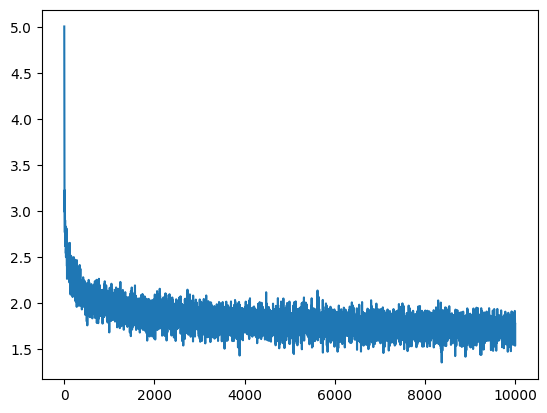

In [278]:
plt.plot(times, losses)

In [299]:
context = torch.zeros((1, block_size), dtype=torch.long, device=device)
output = model.generate(context, num_tokens=500)

In [300]:
print(''.join(decode(output[0].tolist()[block_size:])))

<<THIS mutwoxt; becn, naves their staboing then tnear strings; mother?
    Have offen them, strence? That besenct from to would
     For with thought, for by tooth the princle holn brangs
    that your peopblusude till quint,
    There for thesee have count ry dare sdings, to then genny bring;
    And friendsty, my lordsiou, mere, them have tring, weels _tringen fell
    A grive thren the by brone. Stret, both and intersinance that Pould thyself
    If In trinness not the charit
    Then mpselve
